### Recommendation on 3 books

In [1]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
#import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [45]:
import pandas_gbq
import numpy_financial as npf
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

## Variables for all books

In [5]:
threshold_moic=2.25
annual_interest_rate =0.15
factor_ak_loan=0.75
last_year_collection_date=2024
last_month_collection_date=9


## Multitude AU Oct 21

In [7]:
###Manual:
book_id='3435712288'

In [8]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=float(abs(df_purch.iloc[0,1]))
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=float(abs(df_purch.iloc[0,1]))
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price=0.0
price= purchase_value
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=L9UQwoCcpBknoJBKGMUJ8w8t7QRibA&prompt=consent&access_type=offline
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


In [9]:
df_cf.head() 

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,cum_sum_actual_amount,cum_sum_target_prediction_amount,irr_factor_temp,remaining_months,factor_irr,factor_irr_calculation,actual_amount_temp_irr_internal,irr,irr_yearly
0,3435712288,Multitude AU Oct 21,1,11,2021,432210.25,325022.17,28090.08,21123.75,0.66,0.04,432210.25,28090.08,14.386580,119,0.120896,0.879104,432210.25,0.0863,1.700209
1,3435712288,Multitude AU Oct 21,2,12,2021,155443.49,110495.48,28151.71,20011.37,0.89,0.09,587653.74,56241.79,9.448703,118,0.080074,0.919926,155443.49,0.1329,3.469911
2,3435712288,Multitude AU Oct 21,3,1,2022,193742.23,140821.51,28356.57,20610.97,1.18,0.13,781395.97,84598.36,8.236538,117,0.070398,0.929602,193742.23,0.2006,7.969744
3,3435712288,Multitude AU Oct 21,4,2,2022,121042.02,86341.10,28081.37,20030.86,1.37,0.17,902437.99,112679.73,7.008876,116,0.060421,0.939579,121042.02,0.2345,11.528328
4,3435712288,Multitude AU Oct 21,5,3,2022,115673.38,83955.74,33103.12,24026.24,1.54,0.22,1018111.37,145782.85,5.983753,115,0.052033,0.947967,115673.38,0.2574,14.620016


### Finding the 1st month in which MOIC >= threshold_moic (2.25)

In [16]:
first_month_high_moic=int(df_cf[(df_cf.moic>=threshold_moic)]['month_cohort'].min())

### Methodology: 

- Find out the first month in which MOIC >=2.25

- Look for the first 3 consecutive underperforming books: calculate the average gap
- this is the factor for new targets for the 1st iteration

-  Keep monitoring for 3 months. If avg actual below 70% avg new target : recalculate. Otherwise, wait another 3 months.
For Multitude, after 3 months, actual is around 50% of target. So, new iteration is needed (on one hand, we don't want to wait to much. On the other hand, we need to be agile)

In [166]:
df_filtered = df_cf[df_cf['month_cohort'] >= first_month_high_moic]
df_filtered['is_target_higher'] = df_filtered['target_prediction_amount'] > df_filtered['actual_amount']
# Use a rolling window to find the first occurrence of 3 consecutive True values in 'is_target_higher'
df_filtered['consecutive_high_target'] = df_filtered['is_target_higher'].rolling(window=3).apply(lambda x: all(x), raw=True)

# Find the first occurrence of 3 consecutive months where target_prediction_amount > actual_amount
first_3_consecutive = df_filtered[df_filtered['consecutive_high_target'] == 1].iloc[0] if not df_filtered[df_filtered['consecutive_high_target'] == 1].empty else None

In [23]:
first_third_consecutive_underforming = first_3_consecutive[2]

In [25]:
index=df_cf[df_cf.month_cohort==first_third_consecutive_underforming].index[0]

In [27]:
start_index =  index - 2

In [29]:
df_cf_new_target= df_cf.iloc[start_index:index + 1][['book_id','book_name','month_cohort','actual_amount','target_prediction_amount']].copy()
df_cf_new_target['actual_target_gap']=df_cf_new_target['actual_amount']/df_cf_new_target['target_prediction_amount'] -1

avg_3=round(abs(df_cf_new_target['actual_target_gap'].mean()),2)

print('Gap of actual and target')

print('avg last 3 months:', avg_3)


Gap of actual and target
avg last 3 months: 0.35


In [31]:
df_cf.head(5)

,book_id,book_name,month_cohort,calendary_month,calendary_year,actual_amount,actual_amount_usd,target_prediction_amount,target_prediction_amount_usd,moic,moic_target,cum_sum_actual_amount,cum_sum_target_prediction_amount,irr_factor_temp,remaining_months,factor_irr,factor_irr_calculation,actual_amount_temp_irr_internal,irr,irr_yearly
0,3435712288,Multitude AU Oct 21,1,11,2021,432210.25,325022.17,28090.08,21123.75,0.66,0.04,432210.25,28090.08,14.386580,119,0.120896,0.879104,432210.25,0.0863,1.700209
1,3435712288,Multitude AU Oct 21,2,12,2021,155443.49,110495.48,28151.71,20011.37,0.89,0.09,587653.74,56241.79,9.448703,118,0.080074,0.919926,155443.49,0.1329,3.469911
2,3435712288,Multitude AU Oct 21,3,1,2022,193742.23,140821.51,28356.57,20610.97,1.18,0.13,781395.97,84598.36,8.236538,117,0.070398,0.929602,193742.23,0.2006,7.969744
3,3435712288,Multitude AU Oct 21,4,2,2022,121042.02,86341.10,28081.37,20030.86,1.37,0.17,902437.99,112679.73,7.008876,116,0.060421,0.939579,121042.02,0.2345,11.528328
4,3435712288,Multitude AU Oct 21,5,3,2022,115673.38,83955.74,33103.12,24026.24,1.54,0.22,1018111.37,145782.85,5.983753,115,0.052033,0.947967,115673.38,0.2574,14.620016


In [33]:
df_cf['actual_recomm']=np.where(df_cf.month_cohort<=num_values,df_cf.actual_amount, None)

In [35]:
df_cf['target_recomm']=np.where(df_cf.month_cohort<=first_third_consecutive_underforming,df_cf.target_prediction_amount,df_cf.target_prediction_amount*(1-avg_3))

In [37]:
first_third_consecutive_underforming

19

In [39]:
first_month_high_moic

11

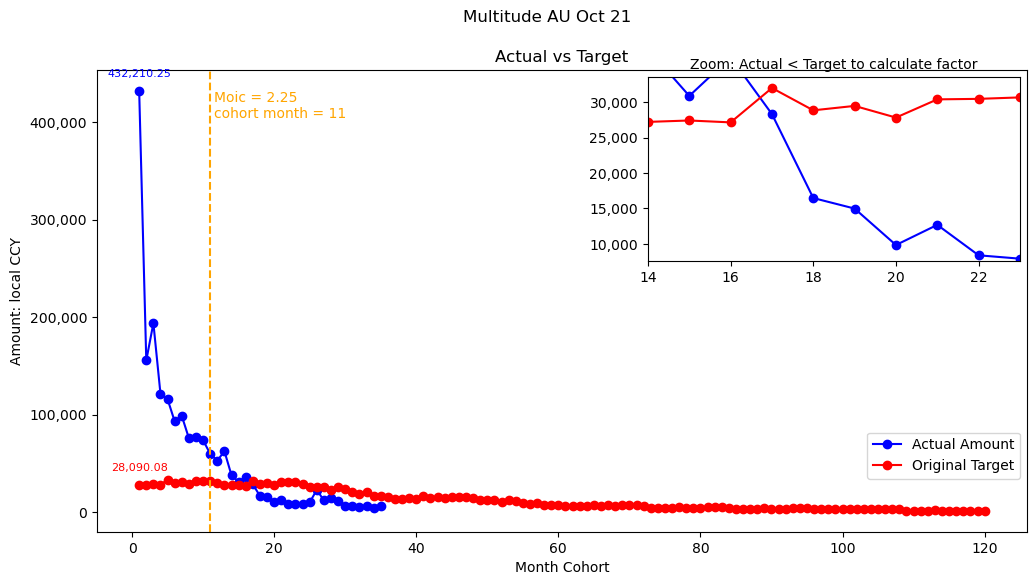

In [47]:
# Reset df_graph to remove any existing index
df_graph = df_cf.reset_index().copy()

plt.figure(figsize=(12, 6))

# Main plot for actual_recomm
plt.plot(df_graph['month_cohort'], df_graph['actual_recomm'], color='blue', label='Actual Amount', linestyle='-', marker='o')
# Annotate the first point for actual_recomm
plt.annotate(f"{df_graph['actual_recomm'].iloc[0]:,}", 
             (df_graph['month_cohort'].iloc[0], df_graph['actual_recomm'].iloc[0]), 
             textcoords="offset points", xytext=(0, 10), ha='center', color='blue', fontsize=8)

# Main plot for target_prediction_amount
plt.plot(df_graph['month_cohort'], df_graph['target_prediction_amount'], color='red', label='Original Target', linestyle='-', marker='o')
# Annotate the first point for target_prediction_amount
plt.annotate(f"{df_graph['target_prediction_amount'].iloc[0]:,}", 
             (df_graph['month_cohort'].iloc[0], df_graph['target_prediction_amount'].iloc[0]), 
             textcoords="offset points", xytext=(0, 10), ha='center', color='red', fontsize=8)

# Adding a vertical line at first_month_high_moic (x=11) and label it
# Add the vertical line in orange
plt.axvline(x=first_month_high_moic, color='orange', linestyle='--')

# Add the text label near the line
plt.text(first_month_high_moic + 0.5, df_graph['actual_recomm'].max(), 
         'Moic = 2.25\ncohort month = {}'.format(first_month_high_moic), 
         color='orange', fontsize=10, va='top', ha='left')

# Adding labels and legend to the main plot
plt.xlabel("Month Cohort")
plt.ylabel("Amount: local CCY")
plt.title("Actual vs Target")
plt.suptitle(book_name, fontsize=12)  # Replace "Book Name" with your actual title
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.1))

# Formatting y-axis with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Creating an inset for zoom
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc="upper right")  # Adjust width, height, and loc as needed
zoom_start, zoom_end = first_third_consecutive_underforming - 5, first_third_consecutive_underforming + 4  # Adjust these to the range you want to zoom into

# Plotting the zoomed region in the inset
ax_inset.plot(df_graph['month_cohort'], df_graph['actual_recomm'], color='blue', linestyle='-', marker='o', label='Actual Amount')
ax_inset.plot(df_graph['month_cohort'], df_graph['target_prediction_amount'], color='red', linestyle='-', marker='o', label='Original Target')

# Setting the x and y limits for the zoomed region
ax_inset.set_xlim(zoom_start, zoom_end)
ax_inset.set_ylim(
    df_graph['actual_recomm'][zoom_start:zoom_end].min() * 0.95,
    df_graph['target_prediction_amount'][zoom_start:zoom_end].max() * 1.05
)

# Adding labels to the inset plot
ax_inset.set_xticks(range(zoom_start, zoom_end + 1, 2))
ax_inset.set_title("Zoom: Actual < Target to calculate factor", fontsize=10)

# Formatting y-axis of the inset with commas
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()


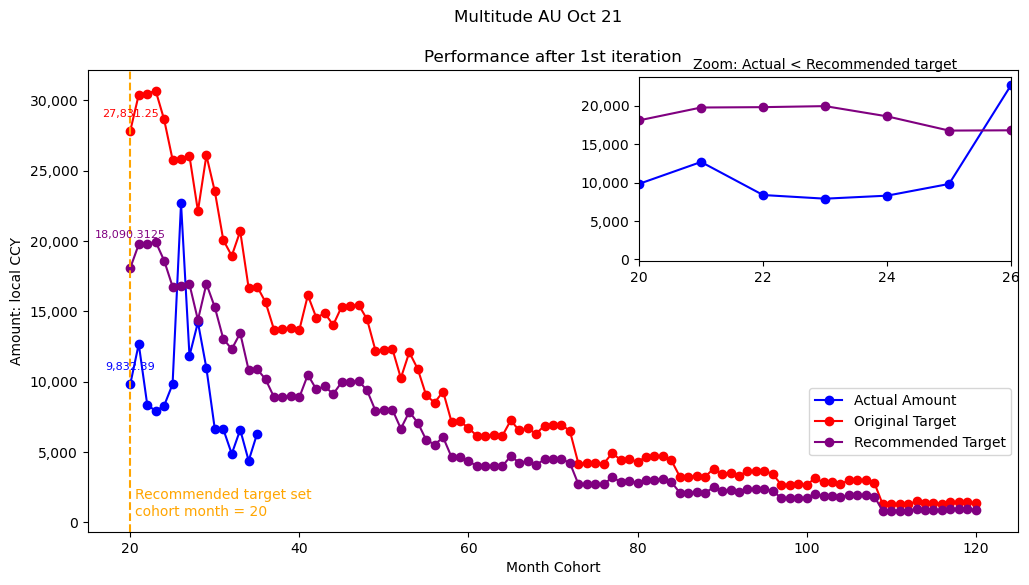

In [176]:
df_graph=pd.DataFrame([])
df_graph = df_cf[(df_cf.month_cohort>=first_third_consecutive_underforming+1)].reset_index().copy()

plt.figure(figsize=(12, 6))

# Main plot for actual_recomm
plt.plot(df_graph['month_cohort'], df_graph['actual_recomm'], color='blue', label='Actual Amount', linestyle='-', marker='o')
# Annotate the first point for actual_recomm
plt.annotate(f"{df_graph['actual_recomm'].iloc[0]:,}", 
             (df_graph['month_cohort'].iloc[0], df_graph['actual_recomm'].iloc[0]), 
             textcoords="offset points", xytext=(0, 10), ha='center', color='blue', fontsize=8)

# Main plot for target_prediction_amount
plt.plot(df_graph['month_cohort'], df_graph['target_prediction_amount'], color='red', label='Original Target', linestyle='-', marker='o')
# Annotate the first point for target_prediction_amount
plt.annotate(f"{df_graph['target_prediction_amount'].iloc[0]:,}", 
             (df_graph['month_cohort'].iloc[0], df_graph['target_prediction_amount'].iloc[0]), 
             textcoords="offset points", xytext=(0, 10), ha='center', color='red', fontsize=8)

# Main plot for target_recomm
plt.plot(df_graph['month_cohort'], df_graph['target_recomm'], color='purple', label='Recommended Target', linestyle='-', marker='o')
# Annotate the first point for target_recomm
plt.annotate(f"{df_graph['target_recomm'].iloc[0]:,}", 
             (df_graph['month_cohort'].iloc[0], df_graph['target_recomm'].iloc[0]),
             textcoords="offset points", xytext=(0, 22), ha='center', color='purple', fontsize=8)

# #Adding a vertical line at first month
# #Add the vertical line in orange
plt.axvline(x=first_third_consecutive_underforming+1, color='orange', linestyle='--')

# # Add the text label near the line

plt.annotate(
    'Recommended target set\ncohort month = {}'.format(first_third_consecutive_underforming + 1), 
    xy=(first_third_consecutive_underforming + 1 + 0.5, df_graph['target_prediction_amount'].min()),  # Anchor point
    xytext=(0, -10),  # Offset (x, y) in points
    textcoords='offset points',  # Use offset in points
    color='orange', fontsize=10, ha='left', va='bottom')

# Adding labels and legend to the main plot
plt.xlabel("Month Cohort")
plt.ylabel("Amount: local CCY")
plt.title("Performance after 1st iteration")
plt.suptitle(book_name, fontsize=12)  # Replace "Book Name" with your actual title
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.15))

##Formatting y-axis with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

##Creating an inset for zoom
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc="upper right")  # Adjust width, height, and loc as needed
###below manual (23: 3 months after the new target)
zoom_start, zoom_end = 23 - 3, 23+ 3  # Adjust these to the range you want to zoom into

##Plotting the zoomed region in the inset
ax_inset.plot(df_graph['month_cohort'], df_graph['actual_recomm'], color='blue', linestyle='-', marker='o', label='Actual Amount')
ax_inset.plot(df_graph['month_cohort'], df_graph['target_recomm'], color='purple', linestyle='-', marker='o', label='Recommended Target')

##Setting the x and y limits for the zoomed region
ax_inset.set_xlim(zoom_start, zoom_end)
# ax_inset.set_ylim(
#     df_graph['actual_recomm'][zoom_start:zoom_end].min() * 1,
#     df_graph['target_recomm'][zoom_start:zoom_end].max() * 1)

##Adding labels to the inset plot
ax_inset.set_xticks(range(zoom_start, zoom_end + 1, 2))
ax_inset.set_title("Zoom: Actual < Recommended target", fontsize=10)

##Formatting y-axis of the inset with commas
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

##### Creating a nd interaction on month 23 (looking avg 3 months).Actual is still below the target

In [55]:
index=df_cf[df_cf.month_cohort==first_month_high_moic].index[0]
# start_index = max(0, index - 6)
# df_cf_new_target= df_cf.iloc[start_index:index + 1][['book_id','book_name','month_cohort','actual_amount','target_prediction_amount']].copy()
df_cf_new_target= df_cf.iloc[:index + 1][['book_id','book_name','month_cohort','actual_amount','target_prediction_amount']].copy()
df_cf_new_target['actual_target_gap']=df_cf_new_target['actual_amount']/df_cf_new_target['target_prediction_amount'] -1

In [65]:
print('mean gap: ',df_cf_new_target['actual_target_gap'].mean())
print('median gap: ',df_cf_new_target['actual_target_gap'].median())


mean gap:  3.6515384773812416
median gap:  2.230182890329107


In [49]:
avg_6=df_cf_new_target['actual_target_gap'].tail(6).mean()
median_6=df_cf_new_target['actual_target_gap'].tail(6).median()

avg_3=df_cf_new_target['actual_target_gap'].tail(3).mean()
median_3=df_cf_new_target['actual_target_gap'].tail(3).median()

In [51]:
print('Gap of actual and target')
print('avg last 6 months:', avg_6)
print('median last 6 months:', median_6)
print('avg last 3 months:', avg_3)
print('median last 3 months:', median_3)

Gap of actual and target
avg last 6 months: 1.6036020947810368
median last 6 months: 1.533039407925737
avg last 3 months: 1.2169681106914796
median last 3 months: 1.3374481744821254


In [57]:
df_cf_new_target

,book_id,book_name,month_cohort,actual_amount,target_prediction_amount,actual_target_gap
0,3435712288,Multitude AU Oct 21,1,432210.25,28090.08,14.386580
1,3435712288,Multitude AU Oct 21,2,155443.49,28151.71,4.521636
2,3435712288,Multitude AU Oct 21,3,193742.23,28356.57,5.832358
3,3435712288,Multitude AU Oct 21,4,121042.02,28081.37,3.310403
4,3435712288,Multitude AU Oct 21,5,115673.38,33103.12,2.494335
5,3435712288,Multitude AU Oct 21,6,92877.99,29842.31,2.112292
6,3435712288,Multitude AU Oct 21,7,98480.75,30487.67,2.230183
7,3435712288,Multitude AU Oct 21,8,75647.75,28782.74,1.628233
8,3435712288,Multitude AU Oct 21,9,76650.94,31442.08,1.437846
9,3435712288,Multitude AU Oct 21,10,73668.91,31516.81,1.337448


In [39]:
index


10